# Investiagtion on interpolation steps

Goal: See wich type of interpolation distance helps best for finding optimal parameters with with relatively deep depth

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_df(name = None):
    # ext = ""
    # if name is not None:
    #    ext = "_" + name
    df1 = pd.read_feather(f"../results/{name}.feather")
    # df2 = pd.read_feather(f"../results/int_2{ext}.feather")
    # dfexp = pd.read_feather(f"../results/int_exp{ext}.feather")

    # df1["method"] = "1-step"
    # df2["method"] = "2-step"
    # dfexp["method"] = "exp-step"

    # df = pd.concat([df1, df2, dfexp], ignore_index=True)
    return df1.query("problem_id < 64 and n_qubits < 16")

In [3]:
df_cmp = load_df("int_qpfp_lin")
df = load_df("int_qpfp")

In [9]:
df

,depth,energy,approx_ratio,feas_ratio,feas_approx_ratio,p_opt,p_999,p_99,p_9,rnd_approx_ratio,...,rge_close,rge_better,rge_worse,rcge_close,rcge_better,rcge_worse,rcge1_close,rcge1_better,rcge1_worse,performance
0,1,-19.813856,0.232784,0.357571,0.651014,0.059695,0.059695,0.059695,0.119798,0.166118,...,True,False,False,True,False,False,True,False,False,same
1,2,-35.141082,0.412212,0.553211,0.745126,0.138054,0.138054,0.138054,0.273954,0.362189,...,False,True,False,False,True,False,False,False,True,same
2,4,-66.267873,0.779405,0.886719,0.878977,0.341766,0.341766,0.341766,0.662595,0.760373,...,False,True,False,False,True,False,False,False,True,same
3,8,-82.536905,0.971027,0.998625,0.972365,0.497863,0.497863,0.497863,0.943302,0.968491,...,False,True,False,False,True,False,False,False,True,same
4,16,-84.133187,0.989812,0.999960,0.989852,0.570384,0.570384,0.570384,0.999853,0.988911,...,False,False,True,False,False,True,False,False,True,same
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,1,-25.671364,0.291707,0.657993,0.443329,0.003105,0.003105,0.003105,0.003105,0.237461,...,True,False,False,False,True,False,False,False,True,same
3196,2,-29.949187,0.340330,0.838116,0.406065,0.007631,0.007631,0.007631,0.007631,0.289797,...,False,False,True,False,True,False,False,False,True,worse
3197,4,-35.410211,0.402390,0.863067,0.466233,0.011941,0.011941,0.011941,0.011941,0.356608,...,False,True,False,False,True,False,False,False,True,same
3198,8,-38.389593,0.436247,0.918480,0.474966,0.012507,0.012507,0.012507,0.012507,0.393058,...,False,False,True,False,True,False,False,False,True,same


In [4]:
df["approx_ratio_cmp"] = df_cmp["approx_ratio"]
df["runtime_cmp"] = df_cmp["runtime"]

df["relative_approx_ratio"] = df.approx_ratio - df.approx_ratio_cmp
df["relative_runtime"] = df.runtime_cmp - df.runtime

df["cum_runtime"] = df.groupby(["n_qubits", "problem_id"]).runtime.cumsum()
df["cum_runtime_cmp"] = df.groupby(["n_qubits", "problem_id"]).runtime_cmp.cumsum()

df["relative_cum_runtime"] = df.cum_runtime_cmp - df.cum_runtime
df["relative_cum_runtime1"] = df.runtime_cmp - df.cum_runtime

df["cum_gradients"] = df.groupby(["n_qubits", "problem_id"]).iterations.cumsum()
df["cum_gradients_cmp"] = df_cmp.groupby(["n_qubits", "problem_id"]).iterations.cumsum()

df["relative_gradients"] = df_cmp.iterations - df.iterations
df["relative_cum_gradients"] = df.cum_gradients_cmp - df.cum_gradients
df["relative_cum_gradients1"] = df_cmp.iterations - df.cum_gradients

<Axes: xlabel='depth', ylabel='relative_approx_ratio'>

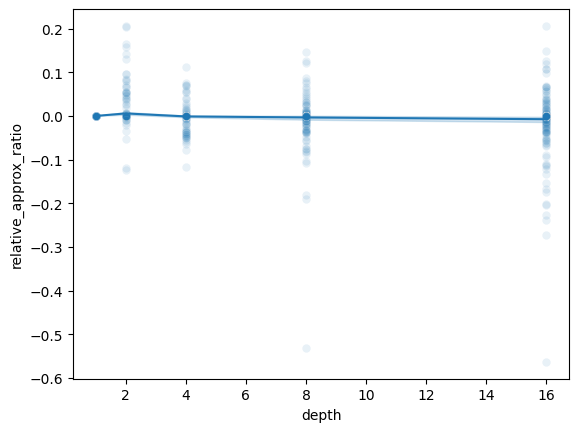

In [10]:
# plt.plot([0, 1], [0, 1], color="k")
sns.scatterplot(df.query("n_qubits == 8"), x="depth", y="relative_approx_ratio", alpha=0.1)
sns.lineplot(df.query("n_qubits == 8"), x="depth", y="relative_approx_ratio")

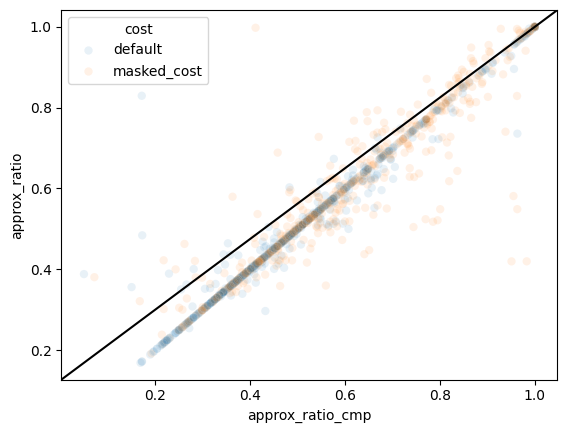

In [44]:
sns.scatterplot(df.query("qaoa == 'quad_penalty_cost'"), x="approx_ratio_cmp", y="approx_ratio", alpha=0.1, hue="cost")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color="k")

In [12]:
def compute_better_worse(metric, abbr):
    df[f"{abbr}_close"] = df[metric].transform(lambda x: np.isclose(x, 0))
    df[f"{abbr}_better"] = df[metric].transform(lambda x: not np.isclose(x, 0) and x > 0)
    df[f"{abbr}_worse"] = df[metric].transform(lambda x: not np.isclose(x, 0) and x < 0)

    #df[f"{abbr}_mean"] = df[metric].transform(lambda x)

compute_better_worse("relative_approx_ratio", "rar")
compute_better_worse("relative_runtime", "rrt")
compute_better_worse("relative_cum_runtime", "rcrt")
compute_better_worse("relative_cum_runtime1", "rcrt1")
compute_better_worse("relative_gradients", "rge")
compute_better_worse("relative_cum_gradients", "rcge")
compute_better_worse("relative_cum_gradients1", "rcge1")

df["performance"] = df.apply(lambda x: "same" if np.isclose(0, x.relative_approx_ratio) else ("better" if x.relative_approx_ratio > 0 else "worse"), axis=1)

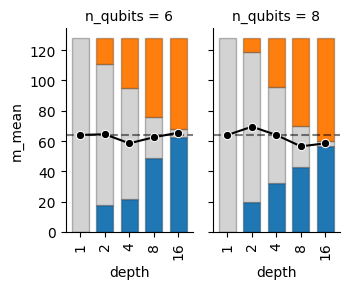

In [42]:
depths = [1, 2, 4, 8, 16]
dfx = df.query("depth in @depths and qaoa == 'quad_penalty_cost'")

fg = sns.FacetGrid(dfx, col="n_qubits", aspect=0.6)

def plot_cmp(data, name="depth", metric="rar", **kwargs):
    df_ac = data.groupby(name)[[f"{metric}_better", f"{metric}_close", f"{metric}_worse"]].sum()
    N = df_ac.sum(axis=1)
    df_ac.plot(ax=plt.gca(), kind="bar", stacked=True, color=["tab:blue", "lightgray", "tab:orange"], edgecolor="#00000044", width=0.7)
    df_ac["m_mean"] = N / 2 + 1 / 2 * (df_ac[f"{metric}_better"] - df_ac[f"{metric}_worse"])
    df_ac["x"] = np.arange(len(depths))
    plt.gca().axhline(y=N.mean() / 2, color="k", linestyle="--", alpha=0.5)
    sns.lineplot(df_ac, x="x", y="m_mean", ax=plt.gca(), color="black", marker="o")

fg.map_dataframe(plot_cmp, name="depth", metric="rar")

In [488]:
df["relative_cum_runtime"]

0      -0.000305
1      -0.000377
2       0.000543
3       0.000252
4       0.004281
          ...   
1595   -0.000808
1596   -0.017225
1597   -0.127200
1598   -0.408665
1599   -0.391415
Name: relative_cum_runtime, Length: 1600, dtype: float64

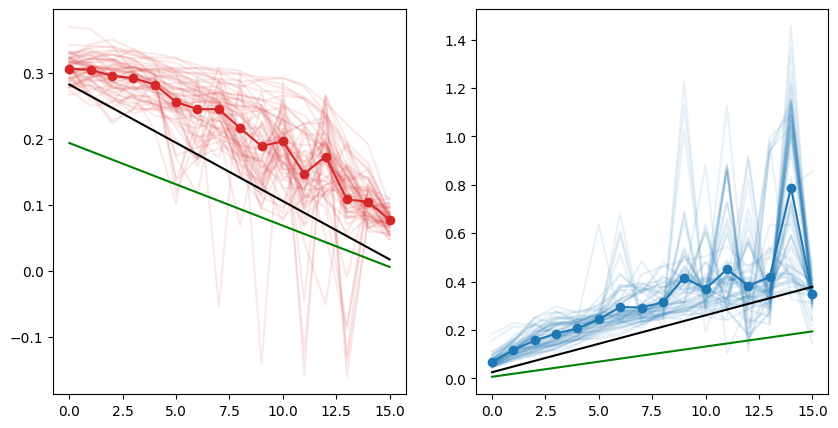

In [509]:
from fastqaoa.params import init_linear



dfx = df_cmp.query("depth == 16 and n_qubits == 10")
betas = np.array(dfx.betas.to_list())
gammas = np.array(dfx.gammas.to_list())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(betas.T, color="tab:red", alpha=0.1)
ax2.plot(gammas.T, color="tab:blue", alpha=0.1)

ax1.plot(betas.mean(axis=0), color="tab:red", marker="o")
ax2.plot(gammas.mean(axis=0), color="tab:blue", marker="o")

b, g = init_linear(betas.shape[1])

ax1.plot(0.15 * b, color="k")
ax2.plot(0.2 * g, color="k")

r = (np.arange(betas.shape[1]) + 0.5) / betas.shape[1]
ax1.plot(0.2 * (1 - r), color="green")
ax2.plot(0.2 * r, color="green")

# Findings
- Linear initialization performs equally good (even slightly better than) interpolation
- Exponetial steps is equally good as linear steps in interpolation
- L-BFGS outperforms Adam generally in number of gradient evaluations and number approximation ratio

In [553]:
df.iterations

0         10
1         16
2         24
3         86
4        736
        ... 
1915     455
1916     337
1917    1048
1918    1048
1919    1078
Name: iterations, Length: 1920, dtype: int64